<a href="https://colab.research.google.com/github/corralem/MITFutureMakers/blob/main/GenderClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os # accessing directory structure
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt # plotting
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

# Set Seed
np.random.seed(11)
set_seed(11)
random.seed(11)

In [ ]:
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
age_gender_data = pd.read_csv("age_gender.csv")
age_gender_data.info()

/content/age_gender.csv
/content/.config/.last_opt_in_prompt.yaml
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/gce
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/configurations/config_default
/content/.config/logs/2021.07.16/13.20.22.328313.log
/content/.config/logs/2021.07.16/13.19.23.269640.log
/content/.config/logs/2021.07.16/13.20.21.584309.log
/content/.config/logs/2021.07.16/13.19.58.237112.log
/content/.config/logs/2021.07.16/13.20.04.172291.log
/content/.config/logs/2021.07.16/13.19.42.311157.log
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17860 entries, 0 to 17859
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  -----

In [ ]:
age_gender_data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


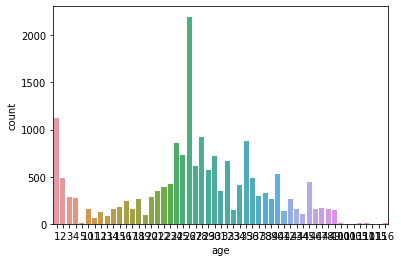

In [ ]:
sns.countplot(x='age', data=age_gender_data) #age distribution

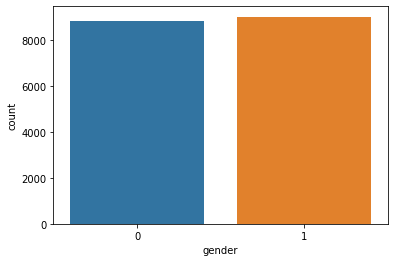

In [ ]:
sns.countplot(x='gender', data=age_gender_data) #gender distribution

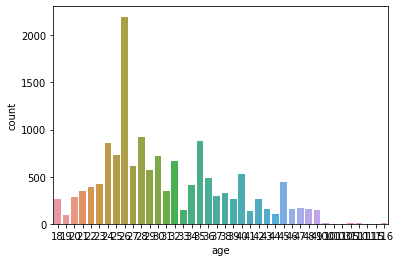

In [ ]:
# Select only person who has age more than 18 
age_gender_data = age_gender_data[age_gender_data['age'] >= 18]
sns.countplot(x='age', data=age_gender_data) #age distribution

In [ ]:
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
14512,49,0,1,20170104235723082.jpg.chip.jpg,84 60 30 23 33 49 69 88 105 109 115 122 123 12...
14513,49,0,1,20170104235655316.jpg.chip.jpg,150 151 154 147 136 147 124 89 105 147 149 169...
14514,49,0,1,20170109220426712.jpg.chip.jpg,93 74 78 109 118 116 89 115 161 173 181 169 20...
14515,49,0,1,20170104213040501.jpg.chip.jpg,49 61 79 93 134 146 95 80 101 105 144 175 150 ...


In [ ]:
age_gender_data.isnull().sum() # Check null data

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [ ]:
# Input image configuration
num_pixels = len(age_gender_data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [ ]:
# Splitting dataset into X and y
X_img = age_gender_data.iloc[:,4].copy()
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()

# splitting the data into train and te sets.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
# splitting 'te' set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

def str_to_npArr(x):
    '''
    Function to convert pixel data (string) into numpy_array of pixels
    '''
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

# Converting the string of pixels into image array for each of train, val and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (10161, 48, 48, 1), type = <class 'numpy.ndarray'>


In [ ]:
target_columns = ['gender', 'ethnicity', 'age']

age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)


                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
14512  84 60 30 23 33 49 69 88 105 109 115 122 123 12...
14513  150 151 154 147 136 147 124 89 105 147 149 169...
14514  93 74 78 109 118 116 89 115 161 173 181 169 20...
14515  49 61 79 93 134 146 95 80 101 105 144 175 150 ...
14516  91 90 81 62 64 58 55 53 67 135 162 166 173 174...

[14517 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
14512       1          

In [ ]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (14517, 48, 48, 1)
Current: X Shape: (14517, 48, 48, 1)


In [ ]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

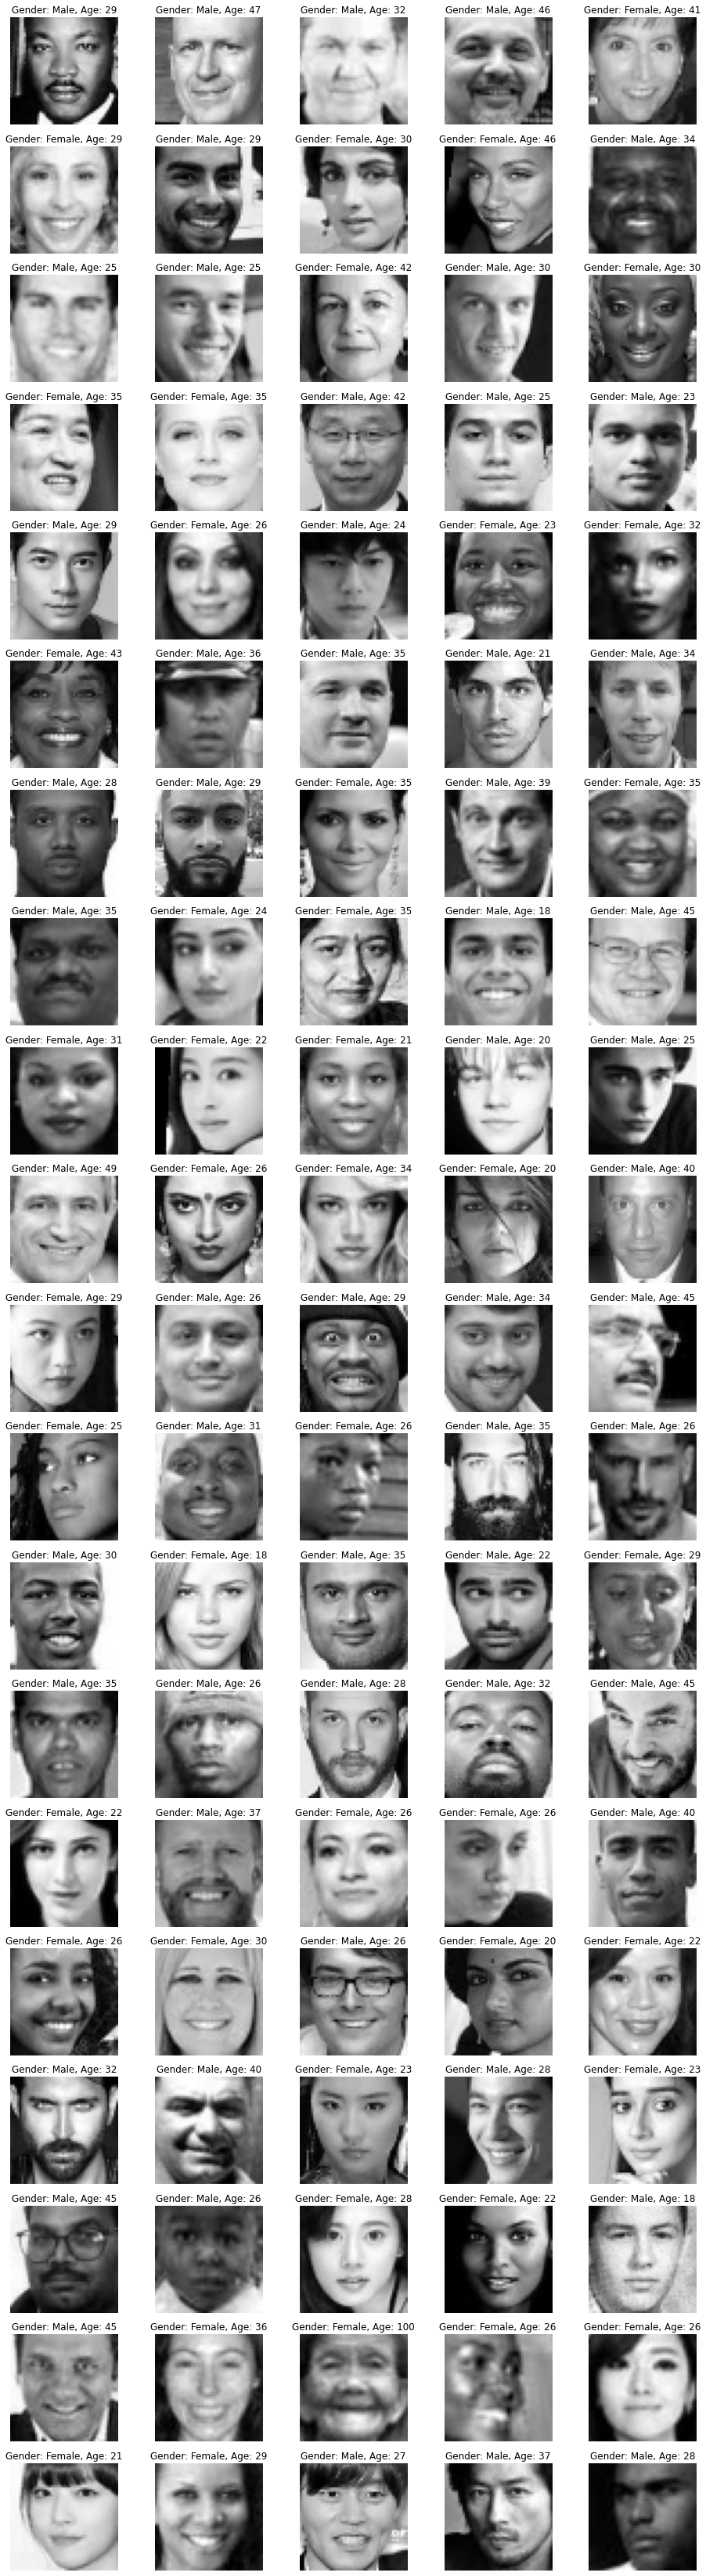

In [ ]:
rows = 20 # rows in subplots
cols = 5 # columns in subplots
samp = random.sample(range(X.shape[0]),rows*cols) #selecting 100 random samples
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

In [ ]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

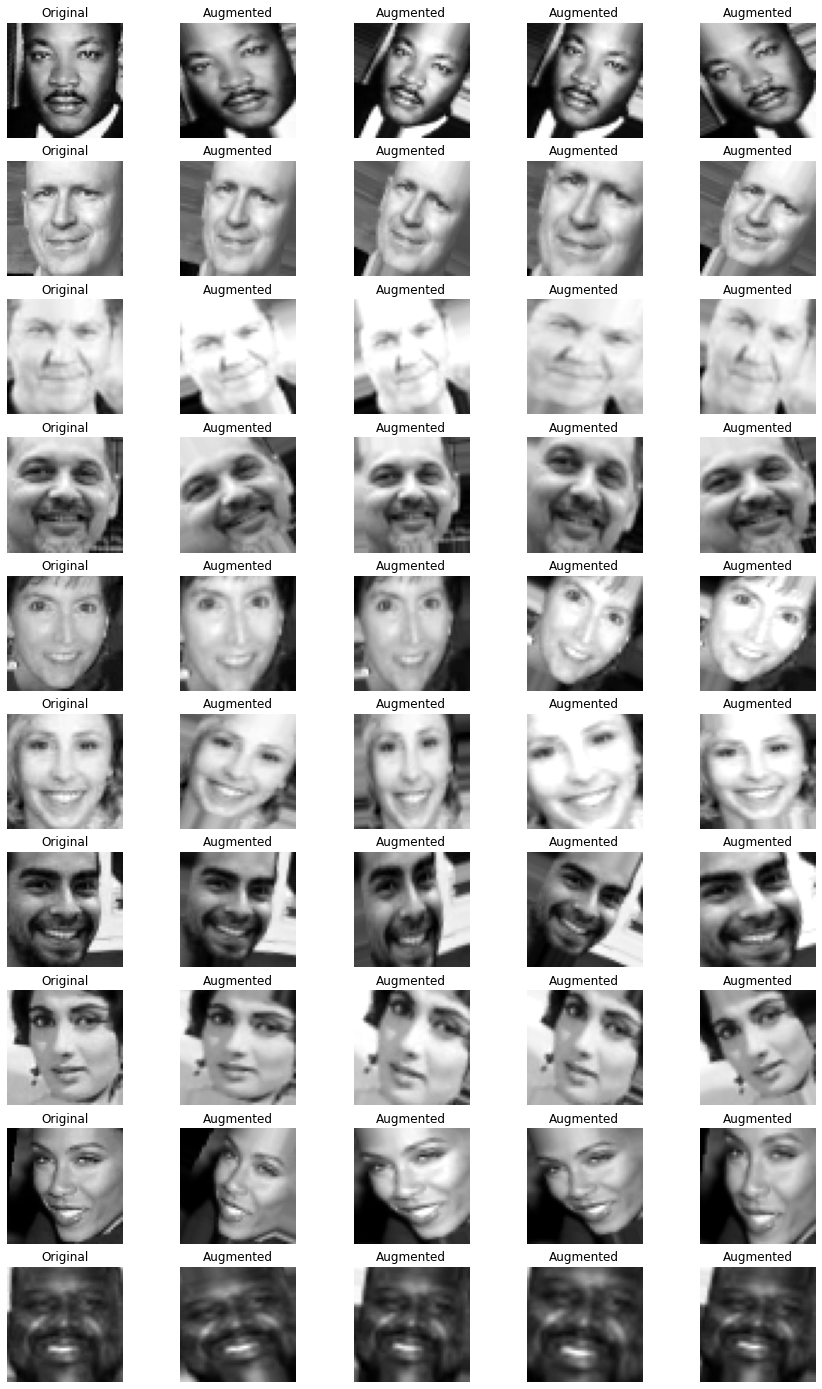

In [ ]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

In [ ]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 2
activation='softmax'

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [ ]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [ ]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
  
  # Define the model architecture
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
  # Fit data to model
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  # Generate generalization metrics
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
227/227 [==============================] - 269s 1s/step - loss: 0.7618 - accuracy: 0.6969 - val_loss: 1.4484 - val_accuracy: 0.4886
Epoch 2/10
227/227 [==============================] - 265s 1s/step - loss: 0.3673 - accuracy: 0.8440 - val_loss: 1.6070 - val_accuracy: 0.5053
Epoch 3/10
227/227 [==============================] - 264s 1s/step - loss: 0.3154 - accuracy: 0.8708 - val_loss: 0.6845 - val_accuracy: 0.6708
Epoch 4/10
227/227 [==============================] - 264s 1s/step - loss: 0.2725 - accuracy: 0.8877 - val_loss: 0.4750 - val_accuracy: 0.7608
Epoch 5/10
227/227 [==============================] - 264s 1s/step - loss: 0.2551 - accuracy: 0.8956 - val_loss: 0.3269 - val_accuracy: 0.8607
Epoch 6/10
227/227 [==============================] - 263s 1s/step - loss: 0.2488 - accuracy: 0.9018 - val_loss: 0.3377 - val_accuracy: 0.8560
Epoch 7/10
227/227 [=========================

Score for fold 1: loss of 0.2681927978992462; accuracy of 89.9848461151123%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
227/227 [==============================] - 264s 1s/step - loss: 0.8223 - accuracy: 0.6398 - val_loss: 0.7728 - val_accuracy: 0.5008
Epoch 2/10
227/227 [==============================] - 267s 1s/step - loss: 0.5600 - accuracy: 0.7153 - val_loss: 0.6616 - val_accuracy: 0.5708
Epoch 3/10
227/227 [==============================] - 268s 1s/step - loss: 0.4683 - accuracy: 0.7852 - val_loss: 0.4327 - val_accuracy: 0.7994
Epoch 4/10
227/227 [==============================] - 266s 1s/step - loss: 0.3823 - accuracy: 0.8341 - val_loss: 0.3456 - val_accuracy: 0.8495
Epoch 5/10
227/227 [==============================] - 263s 1s/step - loss: 0.3331 - accuracy: 0.8588 - val_loss: 0.3123 - val_accuracy: 0.8630
Epoch 6/10
227/227 [==============================] - 264s 1s/step - loss: 0.2998 - accuracy: 0.8741 - val_loss:

Score for fold 2: loss of 0.3181320130825043; accuracy of 86.63543462753296%


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2681927978992462 - Accuracy: 89.9848461151123%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.3181320130825043 - Accuracy: 86.63543462753296%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 88.31014037132263 (+- 1.6747057437896729)
> Loss: 0.29316240549087524
------------------------------------------------------------------------


In [ ]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)
  
# Define the model architecture
model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [30]:
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val,
                                   seed=11)

random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=11),batch_size=32,epochs=20, validation_data=val_data)

Epoch 1/20
454/454 [==============================] - 451s 992ms/step - loss: 0.6217 - accuracy: 0.7167 - val_loss: 1.7571 - val_accuracy: 0.4905
Epoch 2/20
454/454 [==============================] - 456s 1s/step - loss: 0.3780 - accuracy: 0.8379 - val_loss: 0.6782 - val_accuracy: 0.6664
Epoch 3/20
454/454 [==============================] - 449s 990ms/step - loss: 0.2948 - accuracy: 0.8809 - val_loss: 0.2552 - val_accuracy: 0.8990
Epoch 4/20
454/454 [==============================] - 447s 985ms/step - loss: 0.2565 - accuracy: 0.8972 - val_loss: 0.2287 - val_accuracy: 0.9133
Epoch 5/20
454/454 [==============================] - 447s 986ms/step - loss: 0.2345 - accuracy: 0.9097 - val_loss: 0.2690 - val_accuracy: 0.8879
Epoch 6/20
454/454 [==============================] - 447s 985ms/step - loss: 0.2269 - accuracy: 0.9101 - val_loss: 0.2005 - val_accuracy: 0.9308
Epoch 7/20
454/454 [==============================] - 448s 987ms/step - loss: 0.2156 - accuracy: 0.9162 - val_loss: 0.2303 - va

In [31]:
# Generate generalization metrics
fig = px.line(
final_model_history.history, y=['loss', 'val_loss'],
labels={'index': 'epoch', 'value': 'val_loss'}, 
title='Training History')
fig.show()


# Generate generalization metrics
fig = px.line(
final_model_history.history, y=['accuracy', 'val_accuracy'],
labels={'index': 'epoch', 'value': 'accuracy'}, 
title='Training History')
fig.show()

In [32]:
pwd

'/content'

In [33]:
model.save("backup")

INFO:tensorflow:Assets written to: backup/assets


In [34]:
# Metrics
model.evaluate(test_data)

21/21 [==============================] - 5s 220ms/step - loss: 0.1210 - accuracy: 0.9618


[0.12103640288114548, 0.961773693561554]

In [35]:
y_pred = model.predict_classes(test_data)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       312
           1       0.97      0.96      0.96       342

    accuracy                           0.96       654
   macro avg       0.96      0.96      0.96       654
weighted avg       0.96      0.96      0.96       654



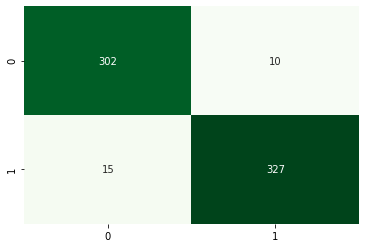

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

In [38]:
error_index = (y_test != y_pred)#finding error indices
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

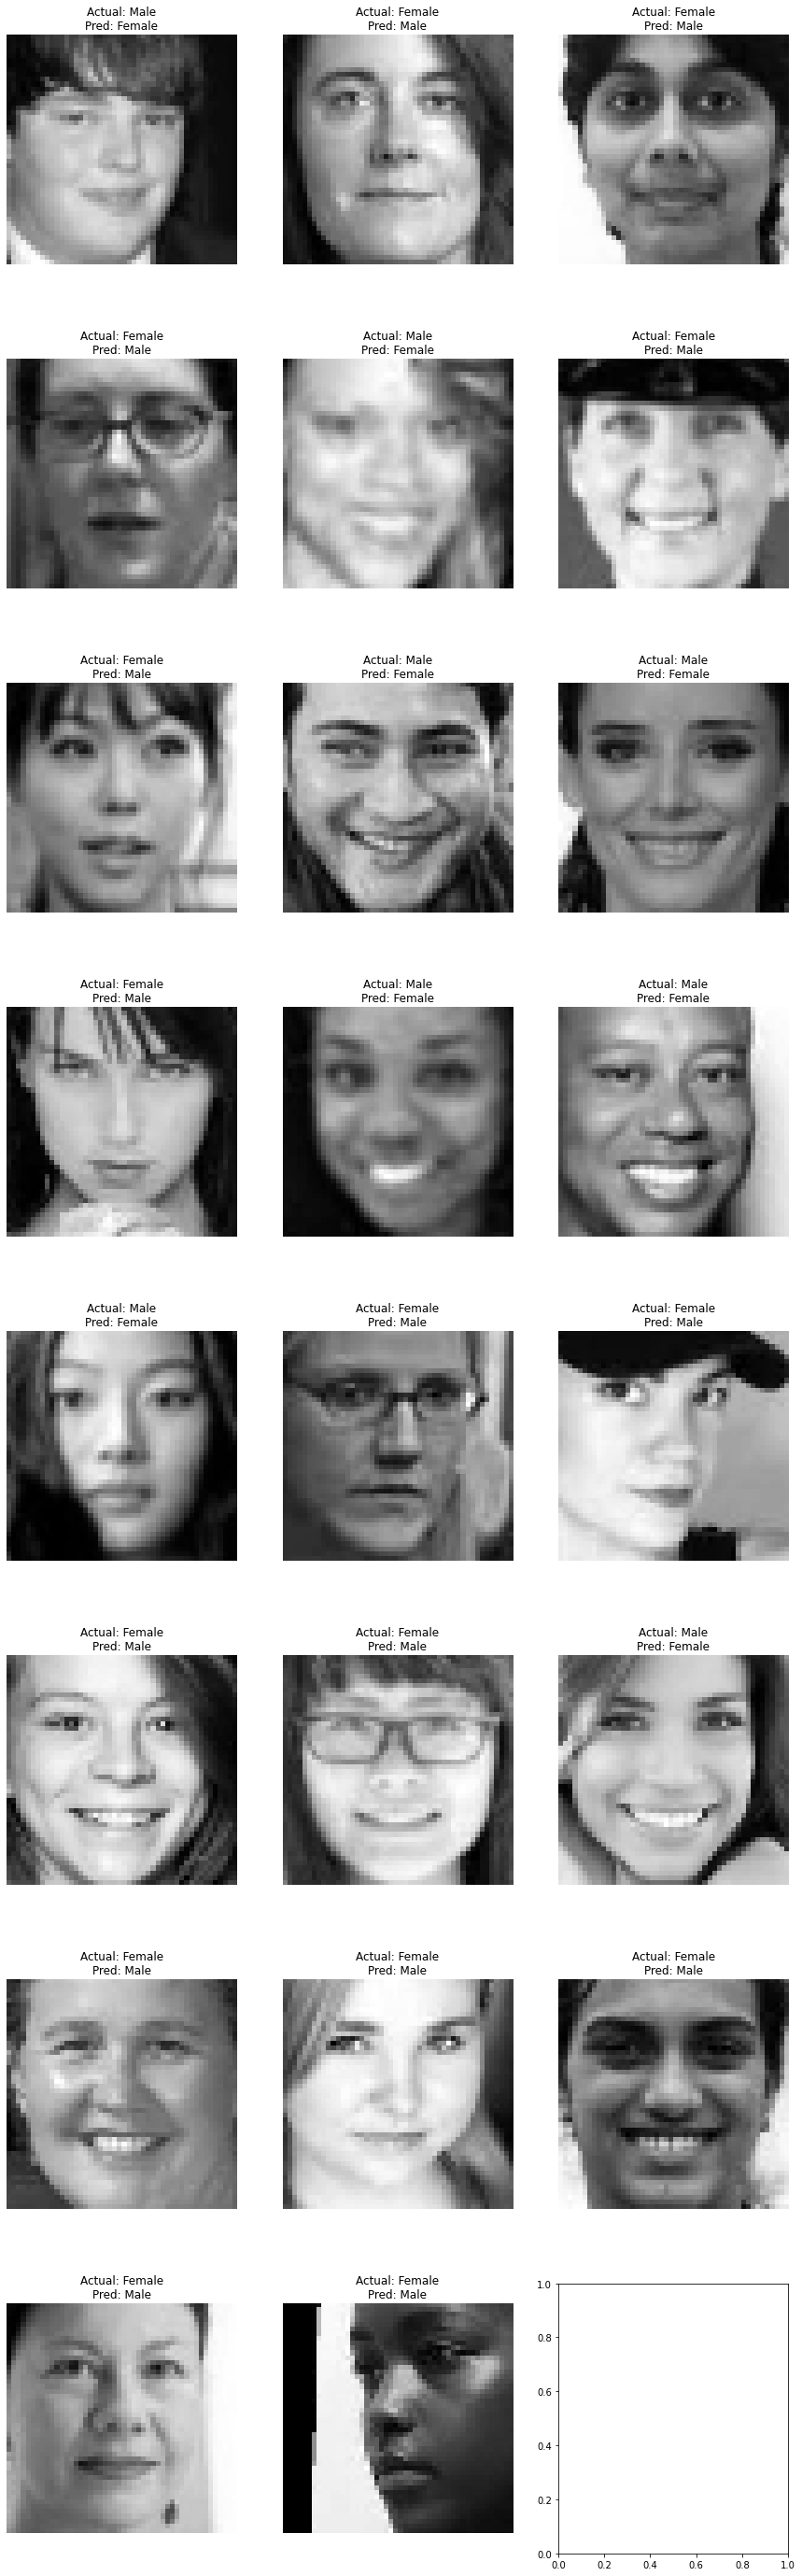

In [39]:
rows=int(np.floor(sum(error_index)/3)) #rows in subplots
cols=3 #columns in subplots
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,50))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp.iloc[i]==1 else "Male"
    pred_lab = "Female" if int(prediction_error[i])==1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()

In [40]:
import cv2

TypeError: ignored

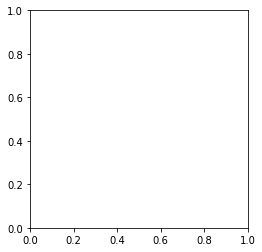

In [41]:
img = cv2.imread('../input/testset/mind-long.jpg',0)
plt.imshow(img, cmap="gray")
img = cv2.resize(img, (48,48))
img = np.reshape(img,[1,48,48,1])
img_pixels = img.astype("float32") / 255.0
classes = model.predict_classes(img_pixels)

mapper=['male','female']
print(mapper[classes[0]])